In [0]:
# https://neurowhai.tistory.com/292

In [0]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3876883829019089860, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5933003659533636849
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12620358854082576940
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11978132078730237417
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from keras import layers, models
from __future__ import print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, Embedding
import numpy as np
from keras import datasets
from keras import backend as K
from keras.utils import plot_model
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt


batch_size = 32  # Batch size for training.
epochs = 120  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/dataset.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
# 전처리
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 문자 -> 숫자 변환용 사전
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 숫자 -> 문자 변환용 사전
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

def RepeatVectorLayer(rep, axis):
  return layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, axis), rep, axis),
                      lambda x: tuple((x[0],) + x[1:axis] + (rep,) + x[axis:]))


# 인코더 생성
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
# dropout 전
# encoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)

encoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)


# 디코더 생성
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens))
# dropout 전
# decoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)
decoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h)

# embedding test




# attention 생성
'''
어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 
인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 
단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 
해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 
집중(attention)해서 보게 됩니다.
'''

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
# 입력을 n 번 반복합니다.
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
# 입력을 n 번 반복합니다.
repeat_e = repeat_e_layer(encoder_outputs)

concat_for_score_layer = layers.Concatenate(axis=-1)
#layers.Concatenate는 입력 목록을 연결하는 계층입니다.
# 연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 사용하고 
# 모든 입력의 연결 인 단일 텐서를 반환합니다.
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_t_score_layer = layers.Dense(latent_dim // 2, activation='tanh')
# Dense 클래스 객체를 TimeDistributed wrapper를 사용하여 3차원 텐서 입력을 받을 수 있게 확장
dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)


dense2_t_score_layer = layers.Dense(1)
# Dense 클래스 객체를 TimeDistributed wrapper를 사용하여 3차원 텐서 입력을 받을 수 있게 확장
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((max_decoder_seq_length, max_encoder_seq_length))(dense2_score)

# soft max 설정
softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

# 입력을 n 번 반복합니다 RepeatVectorLayer
repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

# layers.Permute 주어진 패턴에 따라 입력 치수를 변경합니다.
permute_e = layers.Permute((2, 1))(encoder_outputs)
repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply() # 행렬곱
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
'''입력 목록을 연결하는 계층입니다.
연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 
사용하고 모든 입력의 연결 인 단일 텐서를 반환합니다.'''
concat_context = concat_context_layer([context, decoder_outputs])

attention_dense_output_layer = layers.Dense(latent_dim, activation='tanh')
attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_dense = layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(attention_output)


# 모델 생성
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

che = 'atten_GRU_weight_g.h5'
point = ModelCheckpoint(filepath=che , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1,callbacks=[point,early_stopping])
# Save model
model.save('atten_GRU_weight.h5')
# 


# Next: inference mode (sampling).
# Here's the drill:
# 1) 입력을 인코딩하고 초기 디코더 상태 검색
# 2) 이 초기 상태로 디코더 한 단계 실행
# "시퀀스 시작" 토큰을 대상으로 한다.
# 출력이 다음 대상 토큰임
# 3) 현재 대상 토큰 및 현재 상태로 반복

# 샘플링 모델 정의
encoder_model = models.Model(encoder_inputs, [encoder_outputs, state_h])
encoder_outputs_input = layers.Input(shape=(max_encoder_seq_length, latent_dim))

decoder_inputs = layers.Input(shape=(1, num_decoder_tokens))
decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_outputs, decoder_h = decoder(decoder_inputs, initial_state=decoder_state_input_h)

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(encoder_outputs_input)

concat_for_score_layer = layers.Concatenate(axis=-1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)

dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((1, max_encoder_seq_length))(dense2_score)

softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

permute_e = layers.Permute((2, 1))(encoder_outputs_input)
repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply()
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
concat_context = concat_context_layer([context, decoder_outputs])

attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_att_outputs = decoder_dense(attention_output)

decoder_model = models.Model([decoder_inputs, decoder_state_input_h, encoder_outputs_input],
                            [decoder_outputs, decoder_h, decoder_att_outputs])


def decode_sequence(input_seq):
  # 입력 문장을 인코딩
  enc_outputs, states_value = encoder_model.predict(input_seq)
 
  # 디코더의 입력으로 쓸 단일 문자
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # 첫 입력은 시작 문자인 '\t'로 설정
  target_seq[0, 0, target_token_index['\t']] = 1.
 
  # 문장 생성
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음
    # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨.
    dec_outputs, h, output_tokens = decoder_model.predict(
        [target_seq, states_value, enc_outputs])
 
    # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
 
    # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료
    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
 
    # 디코더의 다음 입력으로 쓸 데이터 갱신
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    states_value = h
 
  return decoded_sentence

for seq_index in range(30):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

Using TensorFlow backend.


Number of samples: 1175
Number of unique input tokens: 780
Number of unique output tokens: 719
Max sequence length for inputs: 165
Max sequence length for outputs: 183




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 165, 780)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 183, 719)     0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 165, 256), ( 796416      input_1[0][0]                    
_

In [0]:
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
x,encoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.2, return_sequences=True, return_state=True)(x)
encoder_outputs, state_h = encoder(encoder_inputs)


# 디코더 생성
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens))
x = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
x,decoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.2, return_sequences=True, return_state=True)(x)
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h)


In [0]:
# 임베딩 사용방법
# 참고용
# 입력 시퀀스 정의와 처리
encoder_inputs = Input(shape=(None,))
x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
x, state_h, state_c = LSTM(latent_dim,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# `encoder_states`를 초기 상태로 사용해 decoder를 설정
decoder_inputs = Input(shape=(None,))
x = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
x = LSTM(latent_dim, return_sequences=True)(x, initial_state=encoder_states)
decoder_outputs = Dense(num_decoder_tokens, activation='softmax')(x)

# `encoder_input_data`와 `decoder_input_data`를 `decoder_target_data`로 반환하도록 모델을 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 컴파일 & 학습 실행
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# `decoder_target_data`는  `decoder_input_data` 같은 정수 시퀀스보단 one-hot 인코딩 형식이 되어야 함.
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

# 검증

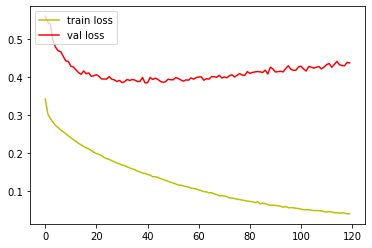

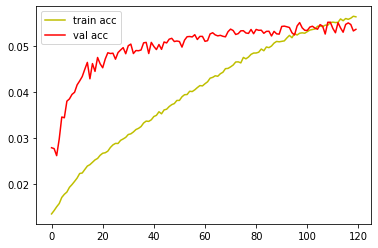

In [0]:
  # 손실 그래프
  plt.plot(history.history['loss'], 'y', label='train loss')
  plt.plot(history.history['val_loss'], 'r', label='val loss')
  plt.legend(loc='upper left')
  plt.show()

  # 정확도 그래프
  plt.plot(history.history['acc'], 'y', label='train acc')
  plt.plot(history.history['val_acc'], 'r', label='val acc')
  plt.legend(loc='upper left')
  plt.show()

모델불러오고 시작

In [0]:
from keras import layers, models
from __future__ import print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional
import numpy as np
from keras import datasets
from keras import backend as K
from keras.utils import plot_model
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt


batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/test.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
# 전처리
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 문자 -> 숫자 변환용 사전
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 숫자 -> 문자 변환용 사전
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

def RepeatVectorLayer(rep, axis):
  return layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, axis), rep, axis),
                      lambda x: tuple((x[0],) + x[1:axis] + (rep,) + x[axis:]))

# 인코더 생성
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
encoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)

# 디코더 생성
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens))
decoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h)

# attention 생성

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
repeat_e = repeat_e_layer(encoder_outputs)

concat_for_score_layer = layers.Concatenate(axis=-1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_t_score_layer = layers.Dense(latent_dim // 2, activation='tanh')
dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)
dense2_t_score_layer = layers.Dense(1)
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((max_decoder_seq_length, max_encoder_seq_length))(dense2_score)

softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

permute_e = layers.Permute((2, 1))(encoder_outputs)
repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply()
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
concat_context = concat_context_layer([context, decoder_outputs])

attention_dense_output_layer = layers.Dense(latent_dim, activation='tanh')
attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_dense = layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(attention_output)
################### model
from keras.models import load_model
history = load_model('/content/atten_GRU_weight_g.h5')
###################
encoder_model = models.Model(encoder_inputs, [encoder_outputs, state_h])
encoder_outputs_input = layers.Input(shape=(max_encoder_seq_length, latent_dim))

decoder_inputs = layers.Input(shape=(1, num_decoder_tokens))
decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_outputs, decoder_h = decoder(decoder_inputs, initial_state=decoder_state_input_h)

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(encoder_outputs_input)

concat_for_score_layer = layers.Concatenate(axis=-1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)

dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((1, max_encoder_seq_length))(dense2_score)

softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

permute_e = layers.Permute((2, 1))(encoder_outputs_input)
repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply()
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
concat_context = concat_context_layer([context, decoder_outputs])

attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_att_outputs = decoder_dense(attention_output)

decoder_model = models.Model([decoder_inputs, decoder_state_input_h, encoder_outputs_input],
                            [decoder_outputs, decoder_h, decoder_att_outputs])


Number of samples: 1203
Number of unique input tokens: 787
Number of unique output tokens: 749
Max sequence length for inputs: 165
Max sequence length for outputs: 183


In [0]:
enc_outputs, states_value = encoder_model.predict(encoder_input_data[2:3])
print(enc_outputs)
print()
print(states_value)

[[[ 0.0845568  -0.04223287  0.01504657 ... -0.01675112  0.01217361
   -0.07913809]
  [-0.01012469 -0.04554577  0.07890618 ... -0.00401536 -0.00055613
   -0.10650092]
  [-0.06501827  0.05378567  0.2214259  ... -0.02666245 -0.05511926
   -0.14034012]
  ...
  [ 0.09179988  0.02620946 -0.1362757  ...  0.20895988 -0.19421019
   -0.08369055]
  [ 0.09182352  0.02621309 -0.13627124 ...  0.20896643 -0.19420826
   -0.08371452]
  [ 0.09184714  0.02621309 -0.1362681  ...  0.20896728 -0.19420315
   -0.08373799]]]

[[ 9.18471441e-02  2.62130871e-02 -1.36268094e-01 -6.08358458e-02
  -7.28430599e-02  1.69694096e-01 -1.23323165e-02  7.65081495e-02
   3.10718752e-02 -1.84719614e-03  1.00338481e-01  3.34279910e-02
   3.96817364e-02 -1.35956854e-01 -1.39421657e-01 -3.15561518e-02
  -5.76024204e-02 -6.05241433e-02  4.81434584e-01 -1.32362813e-01
   3.27997003e-03 -8.01443495e-03 -1.85289495e-02 -1.41692251e-01
  -1.06842995e-01  5.45921910e-04  3.87596935e-01  6.03721961e-02
   8.07228014e-02  3.64684537e-

In [0]:
# def decode_sequence(input_seq):
#   # 입력 문장을 인코딩
#   enc_outputs, states_value = encoder_model.predict(input_seq)
 
#   # 디코더의 입력으로 쓸 단일 문자
#   target_seq = np.zeros((1, 1, num_decoder_tokens))
#   # 첫 입력은 시작 문자인 '\t'로 설정
#   target_seq[0, 0, target_token_index['\t']] = 1.
 
#   # 문장 생성
#   stop_condition = False
#   decoded_sentence = ''
#   while not stop_condition:
#     # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음
#     # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨.
#     dec_outputs, h, output_tokens = decoder_model.predict(
#         [target_seq, states_value, enc_outputs])
 
#     # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환
#     sampled_token_index = np.argmax(output_tokens[0, -1, :])
#     sampled_char = reverse_target_char_index[sampled_token_index]
#     decoded_sentence += sampled_char
 
#     # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료
#     if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
#       stop_condition = True
 
#     # 디코더의 다음 입력으로 쓸 데이터 갱신
#     target_seq = np.zeros((1, 1, num_decoder_tokens))
#     target_seq[0, 0, sampled_token_index] = 1.
    
#     states_value = h
 
#   return decoded_sentence

for seq_index in range(10,1000,20):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

"속슴허라" -> "말하지말라"
"기시리다" -> "초벌로 불에 태우다"
"모소완" -> "무서워"
"물옷" -> "잠수복"
"어멍 " -> "어머니"
"또꼬망 " -> "똥구멍"
"돗괴기 " -> "돼지고기"
"단취 " -> "단추"
"시미옷 " -> "손자용상복"
"요령 " -> "방울"
"작박 " -> "작은바가지"
"잠데 " -> "쟁기"
"물꾸럭 " -> "문어"
"감저 " -> "고구마"
"멘도롱호다 " -> "따뜻하다"
"얼랍지다 " -> "당황하다"
"데싸지다 " -> "자빠지다"
"데껴불다 " -> "던져버리다"
"일고  " -> "일곱"
"통시 " -> "화장실"
"먹엄직이 살암직이 시상" -> "먹어 볼만한 살아 볼만한 세상"
"모멀고루 풀엉 얄룹게 지졍" -> "메밀가루 반죽하여 얇게 지져"
"고루삭삭 삐어지국" -> "사방으로 흩어지고"
"경해그네 어떵 되연" -> "그래서 어떻게 되었어"
"정 골아도 빙세기 웃곡" -> "저렇게 말해도 빙그레 웃고"
"말 골암쩌" -> "말을 하네"
"이래 도라앉작 저래 도라앉작" -> "이리 흔들리고 저리 흔들리고"
"아고 삼촌 물꾸럭 나 얼마마씸?" -> "아고 삼촌 문어 한마리 얼마죠?"
"갭인년 숭년에도 먹당 남은 게 물이여" -> "갑이년 흉년에도 먹다 남은 게 물이다."
"고튼 품이민 홀어멍 칩 머슴산다." -> "같은 값이면 과부집 머슴을 산다."
"끅 걷으레 간 놈이 정당 벌립 망 돌른다." -> "칡 걷으러 간 놈이 정당벌레 테 엮는다."
"놈이 쉐 들럭키는 건 보기 좋나." -> "남의 소 날뛰는 건 보기 좋다."
"남편 옆에 같이 앉으세요" -> "서방 조끝에 고치 앉즙써"
"참말로 이쁘고 둥실둥실합니다" -> "촘말로 곱고 몬트락허우다"
"제주도 오잰하난 폭삭 속아수다" -> "제주도 오느라 수고하셨어요"
"삼성혈가잰하는디예" -> "삼성혈에 가려는데요"
"곱들락 호게 몬뜰락 벗엉 옵서" -> "아름답게 모조리 벗어서 오십시오"
"귀 눈이 왁왁하우다." -> "귀와 눈이 캄캄합니다

테스트셋 만들기.

In [0]:
data_path = '/content/test.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)


In [0]:
input_texts


['\ufeff버래기',
 '바당에 괴기 사레 마씀',
 '무사 누게 왔수과',
 '서울서 족은 아방네 완 마씀',
 '게민 멩심허영 갔당 옵서',
 '고랑은 몰라 마씀',
 '제주도에 왕 봐사 알아짐니다',
 '돌도 많고 보롬도 많고 비바리도 많고',
 '유채꽃도 곱드락 호게 피었수다']

In [0]:
# 테스트 데이터 셋 만들기

from keras import layers, models
from __future__ import print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional
import numpy as np
from keras import datasets
from keras import backend as K
from keras.utils import plot_model
from matplotlib import ticker
import matplotlib.pyplot as plt


data_path = '/content/test.txt'

# Vectorize the data.
input_texts = []

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
# 전처리
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 문자 -> 숫자 변환용 사전
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 숫자 -> 문자 변환용 사전
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Number of samples: 9
Number of unique input tokens: 62
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 22


In [0]:
def decode_sequence(input_seq):
  # 입력 문장을 인코딩
  enc_outputs, states_value = encoder_model.predict(input_seq)
 
  # 디코더의 입력으로 쓸 단일 문자
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # 첫 입력은 시작 문자인 '\t'로 설정
  target_seq[0, 0, target_token_index['\t']] = 1.
 
  # 문장 생성
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음
    # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨.
    dec_outputs, h, output_tokens = decoder_model.predict(
        [target_seq, states_value, enc_outputs])
 
    # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
 
    # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료
    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
 
    # 디코더의 다음 입력으로 쓸 데이터 갱신
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    states_value = h
 
  return decoded_sentence

for seq_index in range(9):
  input_seq = encoder_input_data_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

ValueError: ignored

In [0]:
encoder_model.predict(encoder_input_data[1:2])

[array([[ 0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.6329135e-01,
          6.4644217e-04, -0.0000000e+00, -9.2373818e-02,  2.9097532e-28,
         -0.0000000e+00, -8.5620570e-01,  0.0000000e+00,  0.0000000e+00,
         -9.6190804e-01,  0.0000000e+00,  1.4762883e-31,  0.0000000e+00,
         -2.5769413e-02, -1.5891892e-01,  0.0000000e+00, -0.0000000e+00,
          0.0000000e+00,  0.0000000e+00, -4.8811927e-01, -5.2259541e-01,
          2.4740072e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         -4.8581851e-03, -1.8517128e-01, -0.0000000e+00, -4.0916356e-01,
          0.0000000e+00, -9.0105736e-01, -0.0000000e+00,  5.5774748e-03,
         -2.9330635e-01, -9.8345417e-01,  0.0000000e+00,  0.0000000e+00,
         -0.0000000e+00,  0.0000000e+00, -0.0000000e+00,  3.7912405e-01,
         -8.5560732e-02, -0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
         -2.9002559e-01, -0.0000000e+00,  0.0000000

In [0]:
model.history.history

{'acc': [0.90837691092862,
  0.9354104222362614,
  0.9352390464916024,
  0.9354153230626095,
  0.9354104250135388,
  0.9354104203135309,
  0.9354104260817223,
  0.9354985636194975,
  0.9354740763650573,
  0.9357874575054347,
  0.9370115768952182,
  0.9379859761097953,
  0.9379174260682958,
  0.9392345844631127,
  0.9392052049277931,
  0.9407378007861449,
  0.9414135181348383,
  0.9425886760475815,
  0.94316646681037,
  0.9442583754071198,
  0.9448704377724706,
  0.945830150530757,
  0.9463393848429444,
  0.9472452385023931,
  0.9479160537429181,
  0.9490373484977257,
  0.9495367941890566,
  0.9505209937745098,
  0.9513484948852157,
  0.9521123431489459,
  0.952788058574909,
  0.9535029479252395,
  0.9545067294524134,
  0.9551873378001661,
  0.9555986517219133,
  0.9564947028741188,
  0.9572438636133748,
  0.9581693034872787,
  0.9589380525773571,
  0.9600250680386806,
  0.9607056838637185,
  0.9617731156742274,
  0.9628699238155051,
  0.9635407493105926,
  0.9643927425893831,
  0.96561

In [0]:
for seq_index in range(2):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 5]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 하르방 
Decoded sentence:  감물들인인옷

-
Input sentence: 할망 
Decoded sentence:  감물들인 옷



In [0]:
decoded_sentence[1:3]

'감물'

In [0]:

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 10]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 하르방 
Decoded sentence:  감물들인인옷

-
Input sentence: 할망 
Decoded sentence:  감물들인 옷

-
Input sentence: 아방 
Decoded sentence:  감물들인 옷

-
Input sentence: 어멍 
Decoded sentence:  감물들인인옷

-
Input sentence: 비바리 
Decoded sentence:  돼지

-
Input sentence: 괸당 
Decoded sentence:  바지

-
Input sentence: 걸바시 
Decoded sentence:  바지

-
Input sentence: 넹바리 
Decoded sentence:  감물들인 옷

-
Input sentence: 다슴아돌 
Decoded sentence:  감물들인 옷

-
Input sentence: 말젯놈 
Decoded sentence:  바지

-
Input sentence: 소나이 
Decoded sentence:  바지

-
Input sentence: 성님 
Decoded sentence:  여자

-
Input sentence: 작산 거 
Decoded sentence:  감물들인 옷

-
Input sentence: 좀녀 
Decoded sentence:  여자

-
Input sentence: 촐람생이 
Decoded sentence:  바지

-
Input sentence: 홀아방 
Decoded sentence:  바지

-
Input sentence: 가달 
Decoded sentence:  바지

-
Input sentence: 꼴랑지 
Decoded sentence:  감물들인 옷

-
Input sentence: 구뚱배기 
Decoded sentence:  잠잠하다

-
Input sentence: 꽝 
Decoded sentence:  돼지

-
Input sentence: 굴레 
Decoded sentence:  바지

-
Inpu